In [237]:
import string
import random
from random import randint
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
from PIL import Image, ImageFont, ImageDraw
from scipy import ndimage 
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers

# Part 1: Test generating single letter

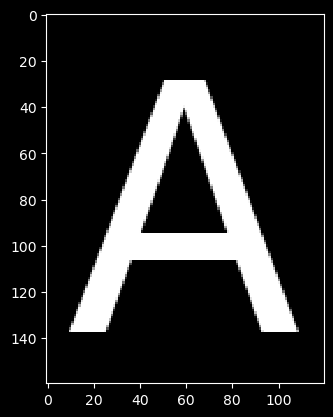

In [238]:
zeros = np.zeros(shape=(160,120), dtype=np.uint8)
# plt.imshow(zeros)
image = Image.fromarray(zeros)
draw = ImageDraw.Draw(image)
font = ImageFont.truetype(r"/usr/share/fonts/truetype/liberation/LiberationMono-Regular.ttf", 165)
text = "A"
draw.text(xy=(10,0), text=text, font=font, fill=255)

letter_image = np.array(image)
plt.imshow(letter_image, cmap='gray')

## 1.2 Dict from Character -> Index

In [239]:
chars = list(string.ascii_uppercase + string.digits)
ctoi = {c:i for i,c in enumerate(chars)}
itoc = {i:c for i,c in enumerate(chars)}
print(ctoi)

{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25, '0': 26, '1': 27, '2': 28, '3': 29, '4': 30, '5': 31, '6': 32, '7': 33, '8': 34, '9': 35}


# Part 2: Generate list of image of each character

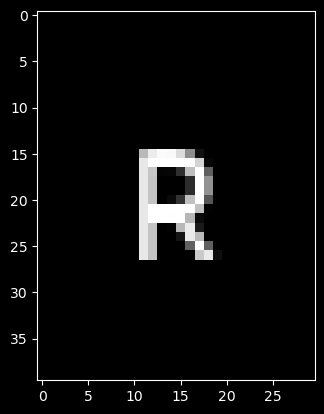

In [240]:
letter_images = []

FONT_HEIGHT = 20


for i in range(36):
    zeros = np.zeros(shape=(int(FONT_HEIGHT * 2), int(FONT_HEIGHT * 1.5)), dtype=np.uint8)
    # plt.imshow(zeros)
    image = Image.fromarray(zeros)
    draw = ImageDraw.Draw(image)
    font = ImageFont.truetype(r"/usr/share/fonts/truetype/ubuntu/UbuntuMono-R.ttf", FONT_HEIGHT)
    text = itoc[i]
    # print(font.getsize(text))
    draw.text(xy=(FONT_HEIGHT*0.5,FONT_HEIGHT*0.5), text=text, font=font, fill=255)
    letter_image = np.array(image)
    letter_images.append(letter_image)

letter_images = np.stack([ im for im in letter_images], axis=0)
letter_images.shape

# show random one
plt.imshow(letter_images[np.random.randint(36)], cmap='gray')

## 2.2: Rotate images

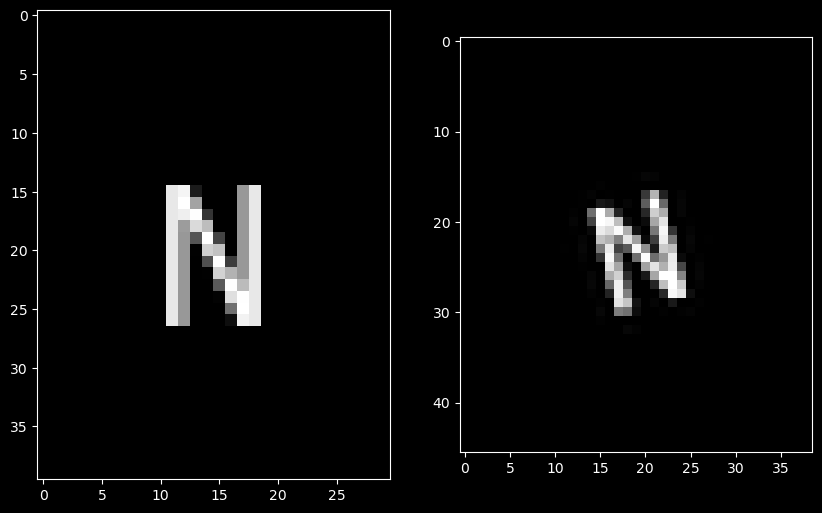

In [241]:
image = letter_images[np.random.randint(0,36)]
rotated = ndimage.interpolation.rotate(image, np.random.randint(-20,20), axes=(0,1), reshape=True)
# show random one 
fig, axs = plt.subplots(1, 2, figsize=(10, 10))
axs[0].imshow(image, cmap='gray')
axs[1].imshow(rotated, cmap='gray')

## 2.3: Shift images

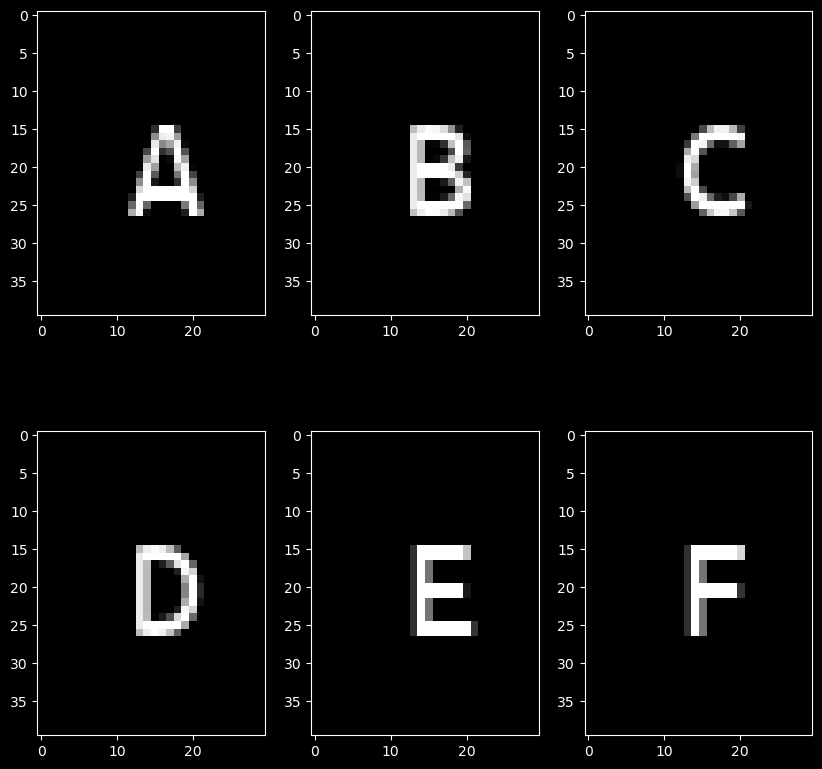

In [242]:
def shift_image_batch(X, dx_range, dy_range):
    out = X.copy()
    dx = np.random.randint(-dx_range, dx_range)
    dy = np.random.randint(-dy_range, dy_range)
    out = np.roll(X, dy, axis=1)
    out = np.roll(X, dx, axis=2)
    if dy>0:
        out[:,:dy, :] = 0
    elif dy<0:
        out[:,dy:, :] = 0
    if dx>0:
        out[:, :, :dx] = 0
    elif dx<0:
        out[:, :, dx:] = 0
    return out



SHIFT_RANGE = 5

fig, axs = plt.subplots(2, 3, figsize=(10, 10)) 
shifted = shift_image_batch(letter_images[:6].copy(), SHIFT_RANGE, SHIFT_RANGE)
for i in range(6):
    axs[i//3, i%3].imshow(shifted[i], cmap='gray')

## 2.4 Perspective Transform

In [243]:
def unit_rand():
    return np.random.rand() * 2 - 1

[[ 0.98489429 -0.06452757 -0.09000579]
 [-0.06026484  1.00335235 -0.13489489]
 [-0.00697226  0.00173113  1.        ]]


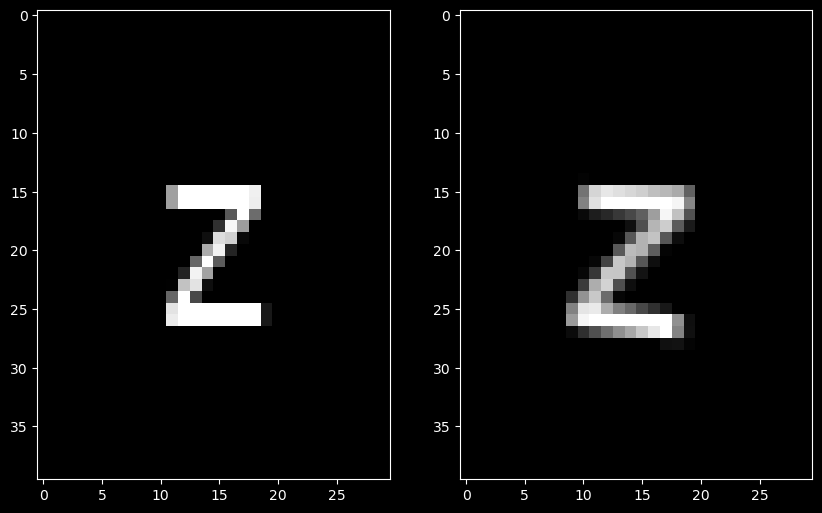

In [244]:
# Locate points of the documents
    # or object which you want to transform
image = letter_images[np.random.randint(0,36)]

RAND_RANGE = 0.8

pts1 = np.float32([[0, 0], [10, 0], [0, 10], [10, 10]])
pts2 = np.float32([[x + RAND_RANGE*unit_rand(), y + RAND_RANGE*unit_rand()] for x, y in pts1])
# Apply Perspective Transform Algorithm
matrix = cv2.getPerspectiveTransform(pts1, pts2)
print(matrix)
result = cv2.warpPerspective(image, matrix, image.T.shape, flags=cv2.INTER_LINEAR)

fig, axs = plt.subplots(1, 2, figsize=(10, 10))
axs[0].imshow(image, cmap='gray')
axs[1].imshow(result, cmap='gray')

# Part 3: Batch-ify it

In [247]:
RAND_RANGE = 0.8

X = letter_images.copy()
Y = tf.one_hot(np.arange(36), depth=36)

for i in range(1000):
    # shifted = shift_image_batch(letter_images, SHIFT_RANGE, SHIFT_RANGE)
    rotated = ndimage.interpolation.rotate(letter_images, np.random.randint(-20,20), axes=(1,2), reshape=False)
    results = []
    for j in range(36):
        pts1 = np.float32([[0, 0], [10, 0], [0, 10], [10, 10]])
        pts2 = np.float32([[x + RAND_RANGE*unit_rand(), y + RAND_RANGE*unit_rand()] for x, y in pts1])
        # Apply Perspective Transform Algorithm
        matrix = cv2.getPerspectiveTransform(pts1, pts2)
        result = cv2.warpPerspective(rotated[j], matrix, rotated[j].T.shape, flags=cv2.INTER_LINEAR)
        contours, hierarchy = cv2.findContours(result, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
        x,y,w,h = cv2.boundingRect(max(contours, key = cv2.contourArea))
        result = cv2.resize(result[y:y+h, x:x+w], result.T.shape)
        results.append(result)

    results = np.stack([ im for im in results], axis=0)
    labels = tf.one_hot(np.arange(36), depth=36)

    X = np.append(X, results, axis=0)
    Y = np.append(Y, labels, axis=0)
X.shape, Y.shape

((36036, 40, 30), (36036, 36))

## 3.1 Sample randomly to validate labels

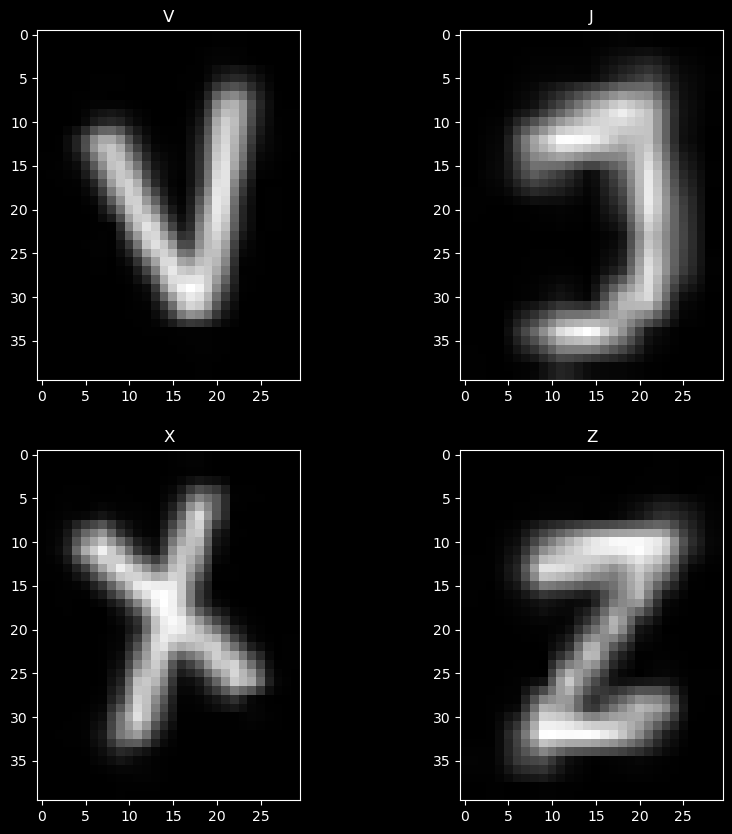

In [260]:
fig, axs = plt.subplots(2,2 , figsize=(10, 10))
for i in range(4):
    N = X.shape[0]
    n = np.random.randint(N)
    axs[i//2, i%2].imshow(X[n], cmap='gray')
    axs[i//2, i%2].set_title(itoc[np.argmax(Y[n])])


## 3.2: Data split

In [261]:
train_split = 0.9
N = X.shape[0]
n = int (N * train_split)
X_train = X[:n]
Y_train = Y[:n]
X_valid = X[n:]
Y_valid = Y[n:]

print(X_train.shape)
print(Y_train.shape)
print(X_valid.shape)
print(Y_valid.shape)

(32432, 40, 30)
(32432, 36)
(3604, 40, 30)
(3604, 36)


[Text(0, 0, 'A'),
 Text(0, 0, 'B'),
 Text(0, 0, 'C'),
 Text(0, 0, 'D'),
 Text(0, 0, 'E'),
 Text(0, 0, 'F'),
 Text(0, 0, 'G'),
 Text(0, 0, 'H'),
 Text(0, 0, 'I'),
 Text(0, 0, 'J'),
 Text(0, 0, 'K'),
 Text(0, 0, 'L'),
 Text(0, 0, 'M'),
 Text(0, 0, 'N'),
 Text(0, 0, 'O'),
 Text(0, 0, 'P'),
 Text(0, 0, 'Q'),
 Text(0, 0, 'R'),
 Text(0, 0, 'S'),
 Text(0, 0, 'T'),
 Text(0, 0, 'U'),
 Text(0, 0, 'V'),
 Text(0, 0, 'W'),
 Text(0, 0, 'X'),
 Text(0, 0, 'Y'),
 Text(0, 0, 'Z'),
 Text(0, 0, '0'),
 Text(0, 0, '1'),
 Text(0, 0, '2'),
 Text(0, 0, '3'),
 Text(0, 0, '4'),
 Text(0, 0, '5'),
 Text(0, 0, '6'),
 Text(0, 0, '7'),
 Text(0, 0, '8'),
 Text(0, 0, '9')]

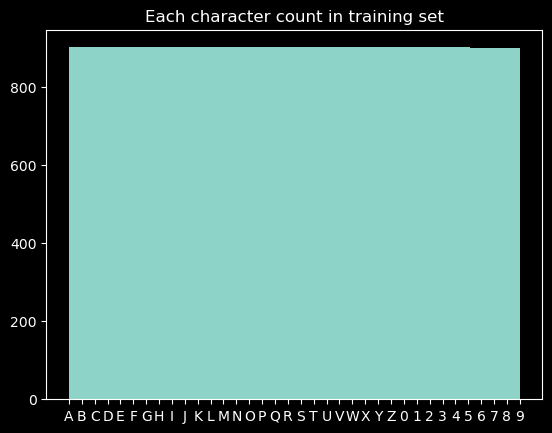

In [285]:
fig, axs = plt.subplots()
axs.hist(np.argmax(Y_train, axis=1), bins=36)
axs.set_title('Each character count in training set')
axs.set_xticks(range(36))
axs.set_xticklabels([c for c in list(ctoi.keys())])

In [289]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(40, 30, 1)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(36))
model.add(layers.Softmax())
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 38, 28, 32)        320       
                                                                 
 conv2d_13 (Conv2D)          (None, 36, 26, 64)        18496     
                                                                 
 conv2d_14 (Conv2D)          (None, 34, 24, 64)        36928     
                                                                 
 flatten_4 (Flatten)         (None, 52224)             0         
                                                                 
 dense_8 (Dense)             (None, 64)                3342400   
                                                                 
 dense_9 (Dense)             (None, 64)                4160      
                                                                 
 dense_10 (Dense)            (None, 64)               

In [291]:
EPOCHS = 4

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

history = model.fit(X_train, Y_train, epochs=EPOCHS, 
                    validation_data=(X_valid, Y_valid))


Epoch 1/4
1014/1014 [==============================] - 60s 59ms/step - loss: 0.1956 - accuracy: 0.9429 - val_loss: 0.0939 - val_accuracy: 0.9709
Epoch 2/4
1014/1014 [==============================] - 59s 58ms/step - loss: 0.0826 - accuracy: 0.9746 - val_loss: 0.1055 - val_accuracy: 0.9664
Epoch 3/4
1014/1014 [==============================] - 60s 59ms/step - loss: 0.0606 - accuracy: 0.9814 - val_loss: 0.0440 - val_accuracy: 0.9853
Epoch 4/4
1014/1014 [==============================] - 62s 61ms/step - loss: 0.0411 - accuracy: 0.9871 - val_loss: 0.0583 - val_accuracy: 0.9836


Text(0.5, 1.0, 'Model Accuracy on validation and training data over 4 epochs')

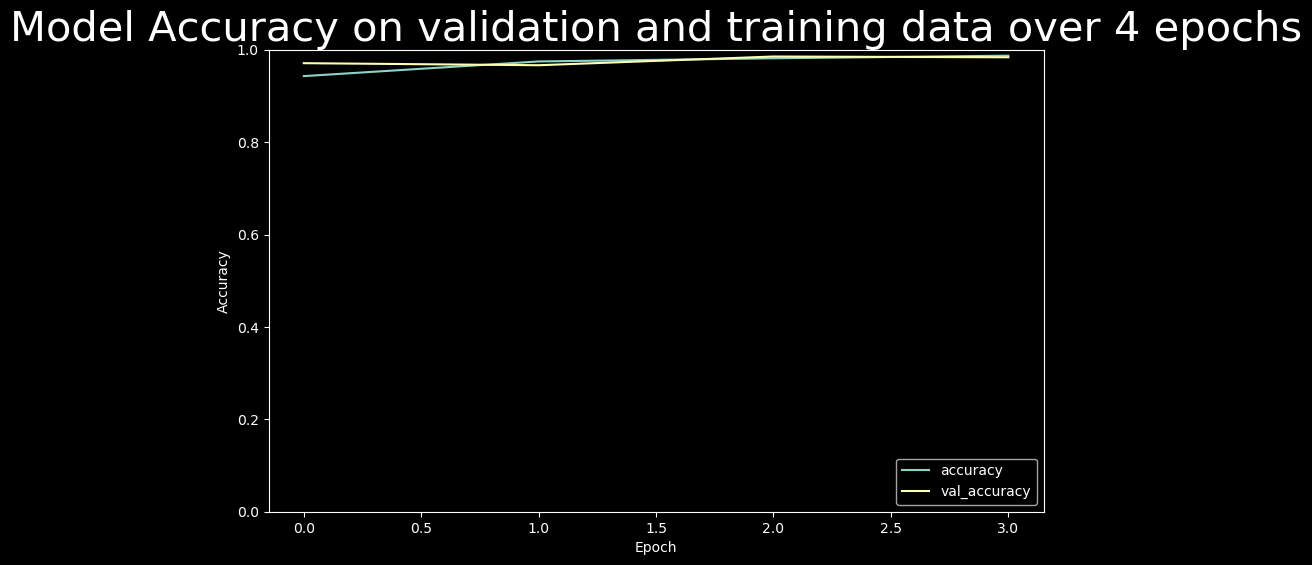

In [292]:

plt.style.use('dark_background')
plt.figure(figsize=(10,6))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.0, 1.0])
plt.legend(loc='lower right')
plt.title(f"Model Accuracy on validation and training data over {EPOCHS} epochs", size=30)

In [2]:

fig, axs = plt.subplots(4,8, figsize=(16,8))
for i in range(32):
    n = np.random.randint(X_valid.shape[0])
    input = tf.expand_dims(tf.expand_dims(X_valid[n], -1), 0)
    label = itoc[np.argmax(Y_valid[n])]
    ypred = str(itoc[np.argmax(model(input))])
    axs[i//8, i%8].imshow(X_valid[n], cmap='gray')
    if label == ypred:
        axs[i//8, i%8].set_title('Model predicts: ' + ypred, color='green')
    else:
        axs[i//8, i%8].set_title('Model predicts: ' + ypred, color='red')
fig.tight_layout()
fig.suptitle('Model predictions', fontsize=24)

NameError: name 'plt' is not defined

: 